In [1]:
import pandas as pd
import numpy as np
from numpy import newaxis
import matplotlib.pyplot as plt
import random
import seaborn as sns
import itertools
import os
from PIL import Image
import math
from matplotlib import gridspec
import matplotlib.collections

from matplotlib.transforms import Affine2D
import mpl_toolkits.axisartist.floating_axes as floating_axes
import matplotlib.collections

from tqdm import *
# nice progress bars otherwise
# def tqdm(x):
#     yield x

In [2]:
# TODO, improvement ideas

# use log(flux) as input
# investigate highest errors (argmax(xi²))

# kfold integration in place of CV
# TTA
# CNN segmentation cleanup 
# resnet v2 ( https://github.com/myutwo150/keras-inception-resnet-v2/blob/master/inception_resnet_v2.py )
# custom CNN features
# CV2 resize cubic interpolation 

# Serge:
# essayer de remplacer lgb par un Deep NN keras (vu la quantité de donnée)


#done
# lgbm eval rmsle instead of rmse
# add image size as feature



In [3]:
# memory debug function

import sys
# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
mm = sorted([(x, sys.getsizeof(globals().get(x)),"{:,}".format(sys.getsizeof(globals().get(x)))) 
        for x in dir() 
           if not x.startswith('_') 
#         and x not in sys.modules
        and x not in ipython_vars], key=lambda x: x[1], reverse=True)




## data folder set up and test

In [4]:
dataFolder = 'data/mainData/'
plt.ion()

runNameParams = []
runNameParams.append('newSource')
# print(runNameParams)

In [5]:
def read_image(id):
    if id[-4:] == '.npy':
        X = np.load(dataFolder+id)
    elif os.path.isfile(dataFolder+id+'.npy'):
        X = np.load(dataFolder+id + '.npy')
    elif os.path.isfile(dataFolder+id+'-g.csv'):
        X = np.genfromtxt(dataFolder+id+'-g.csv', delimiter=",")
    else:
        X = None

    X = np.float32(X)
    return X


In [6]:
dataFileList = []

directory = os.fsencode(dataFolder)

for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith(".npy") or filename.endswith(".py"): 
        dataFileList.append(filename)
        
print(len(dataFileList))

80306


# Check a few random images 


1237652946921455653.npy
1237651539782729807.npy
1237651754555605087.npy
1237655743484330266.npy
1237660764834889937.npy


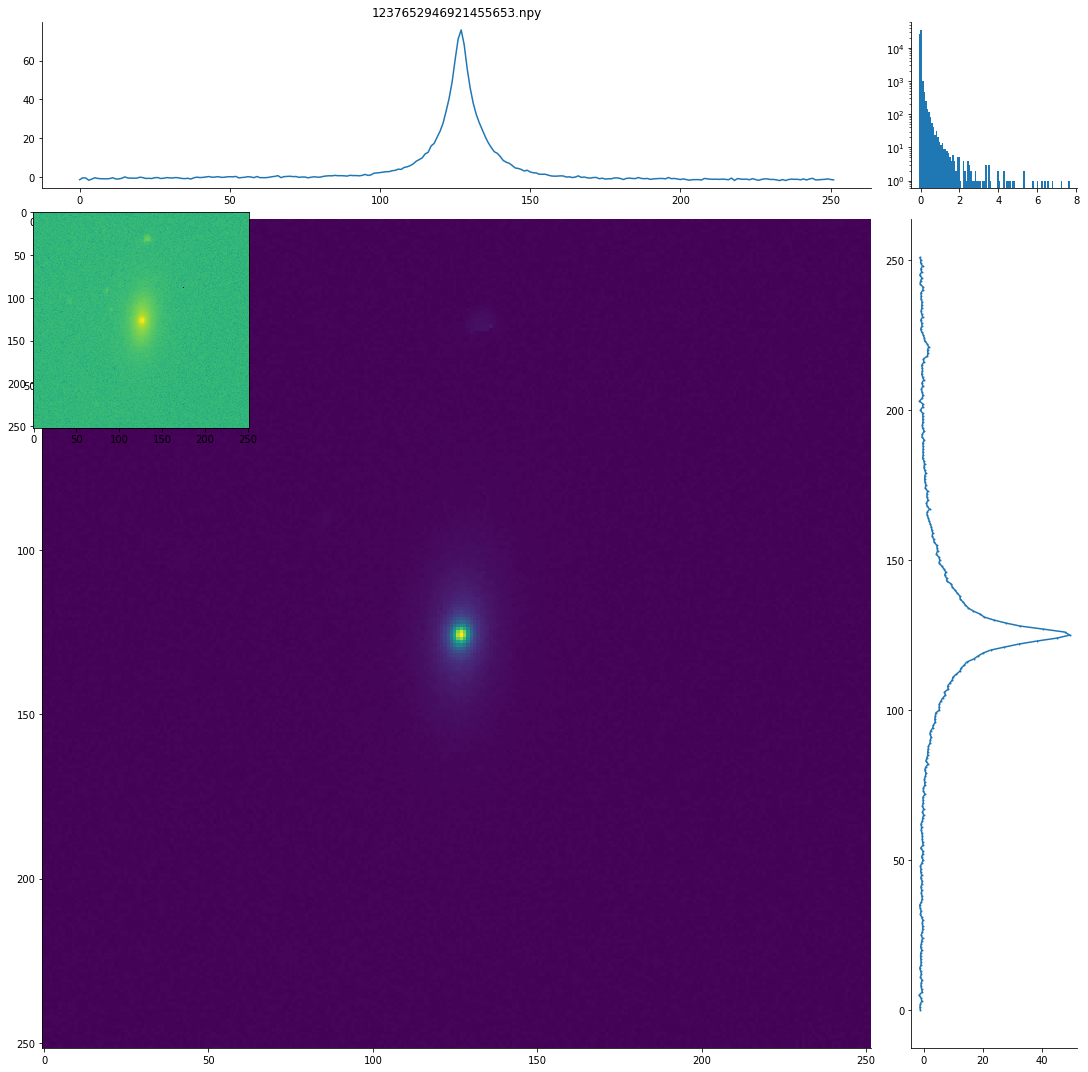

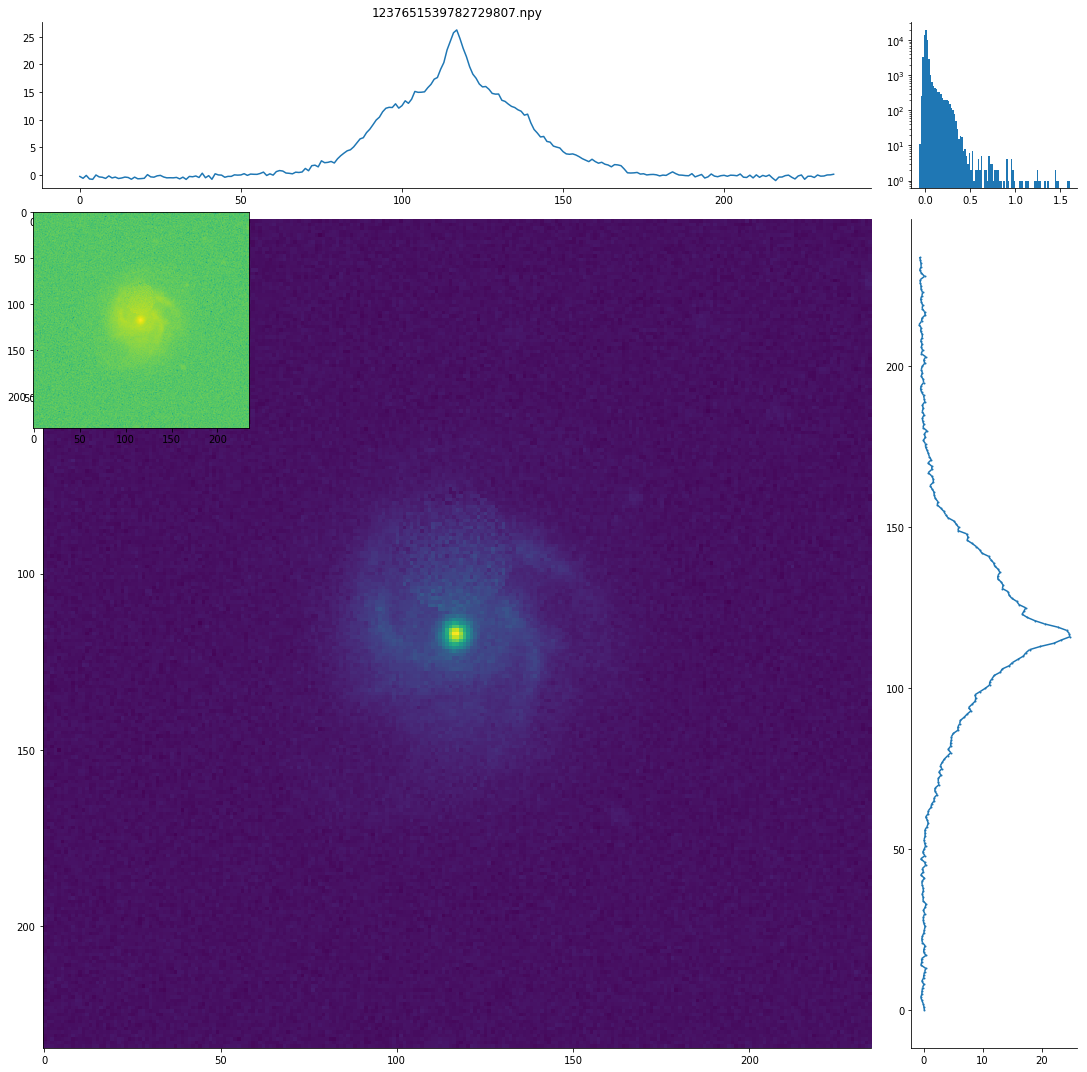

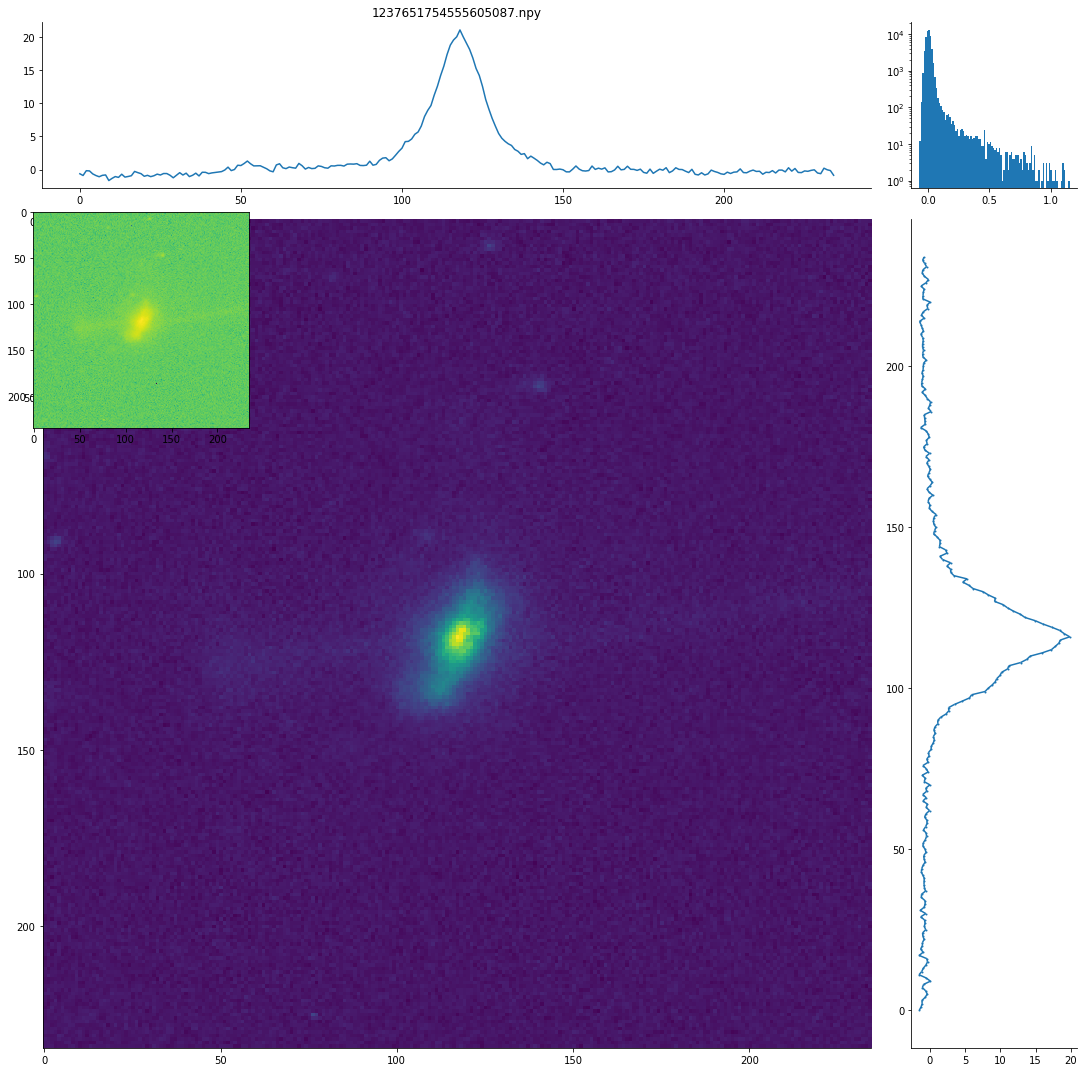

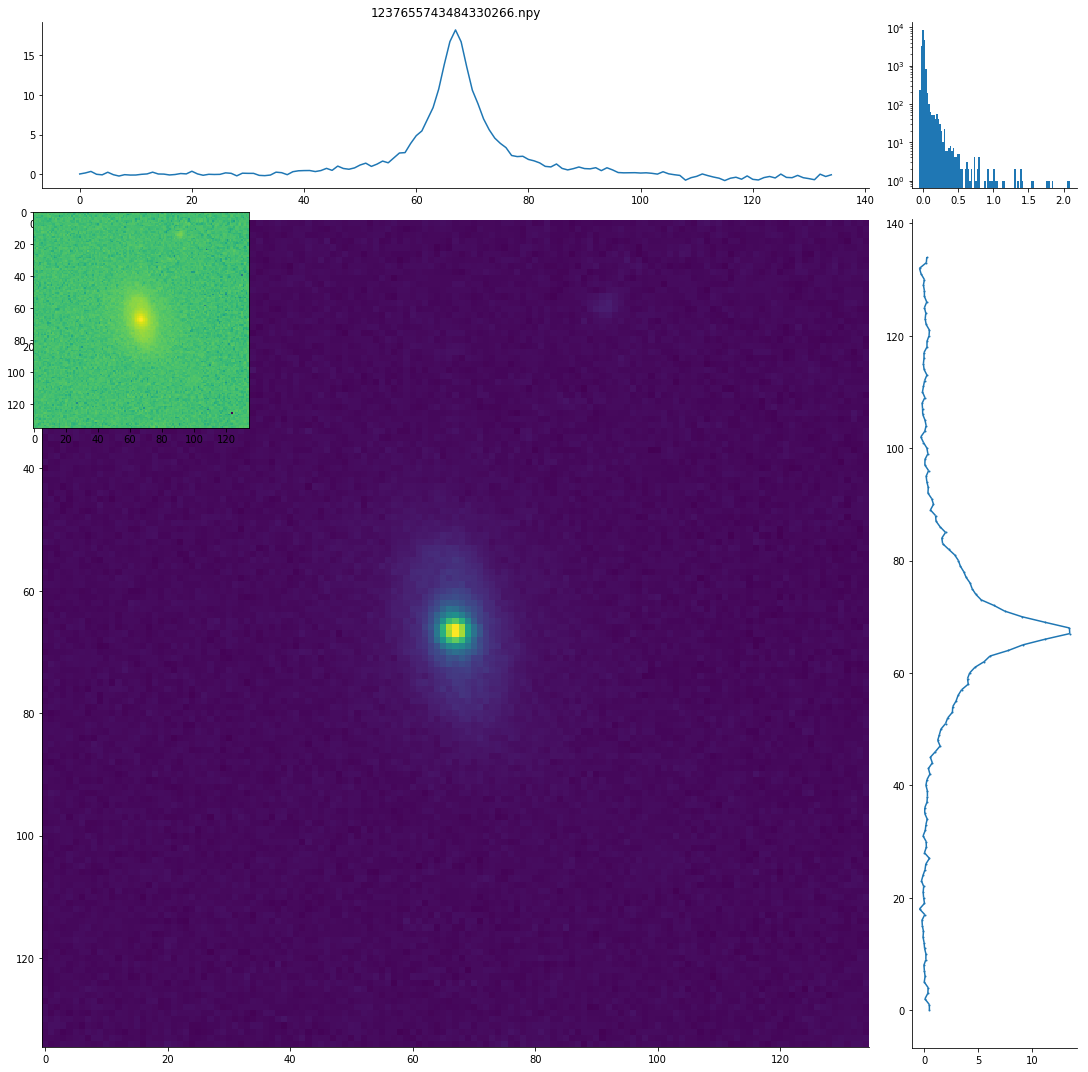

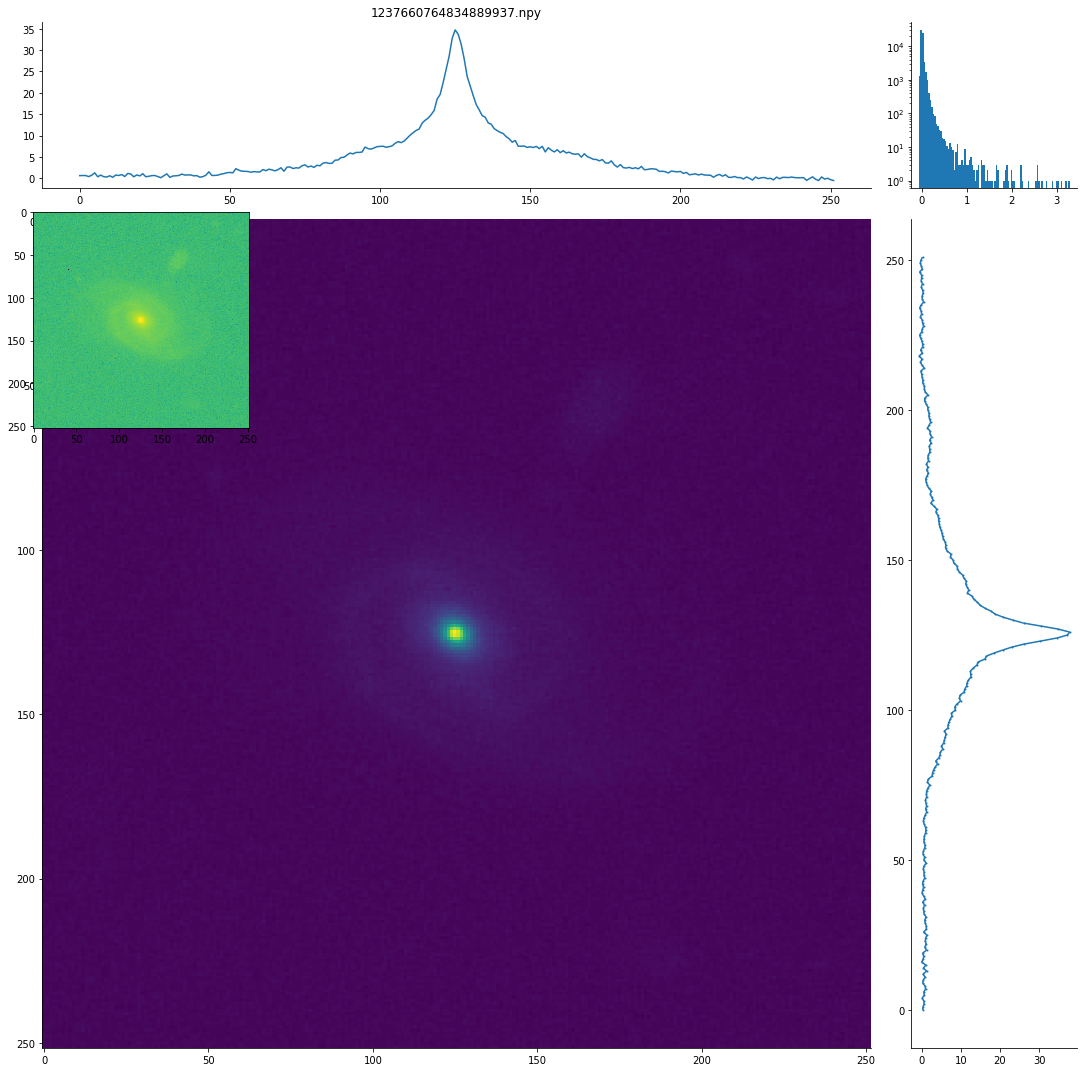

In [7]:
def drawOneGalaxy(galaxyID):
    oneImageData = read_image(galaxyID)
    print(galaxyID)

    # new image
    fig = plt.figure(figsize=(15,15))
    #set grid spec for the 4 graphs
    gs = gridspec.GridSpec(2, 2, width_ratios=[5, 1], height_ratios=[1,5]) 

    #draw image
    plt.title("raw")
    plt.subplot(gs[2])
    plt.imshow(oneImageData)
    
    # horizontal (top) sum
    plt.subplot(gs[0])
    plt.title(galaxyID)
    plt.plot(oneImageData.sum(axis=0))

    # vertical (bottom-right) sum
    ax = plt.subplot(gs[3])
    ss = np.flip(oneImageData.sum(axis=1),axis=0)
    plt.scatter(x=ss, y=list(range(oneImageData.shape[1])), s=1)
    lines = [[(ss[i-1],i-1),(ss[i],i)] for i in range(1,len(ss))]
    lc = matplotlib.collections.LineCollection(lines)
    ax.add_collection(lc)
    
    #value histogram
    plt.subplot(gs[1])
    plt.hist(oneImageData.reshape(-1), bins=100)
    plt.yscale('log')    
    sns.despine()
    plt.tight_layout()

    #add small log of image
    ax = fig.add_axes([0.02,0.6,.2,.2])
    plt.imshow(np.log(oneImageData-oneImageData.min()+0.00001))

for _ in range(5):
    i = random.randint(0,len(dataFileList))
#     oneImageData = np.load(dataFolder+'1237648704067273096.npy')
    drawOneGalaxy(dataFileList[i])
    


In [8]:

issuesImages = ['1237658298983055529.npy','1237660634917634181.npy','1237654879654772871.npy','1237654953205170487.npy','1237651249884627014.npy','1237651754022207627.npy',
 '1237654669736018114.npy','1237655471824568727.npy','1237665530643808416.npy','1237658611444088911.npy','1237667255070490937.npy',
 '1237665531177795774.npy','1237645943975837722.npy','1237658425161220139.npy', '1237665129087435003.npy','1237657873792172224.npy',
 '1237660240313778264.npy','1237668298201432152.npy', '1237662264316264518.npy','1237657630042227294.npy','1237651754550624376.npy',
 '1237667211059986578.npy','1237655470208582145.npy']

# for image in issuesImages:
#     drawOneGalaxy(image)

In [9]:
print('test')

test


# ML part

In [10]:
import pandas as pd
import numpy as np
import cv2
from glob import glob
import xgboost as xgb
from keras.applications import *
import lightgbm as lgbm
import scipy
import tensorflow

/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


In [11]:
def xi2(true,pred,error):
    s=np.mean((true-pred)**2/error**2)
    return s

def normalize_image(Xg):
    Xg -= np.mean(Xg)
    Xg /= np.std(Xg)
    
    return Xg

def crop_image(Xg):
    h,w = Xg.shape
    cy, cx = h//2, w//2
    dy, dx = int(cy*0.75), int(cx*0.75) # crop a bit around center
    Xg = Xg[cy-dy:cy+dy,cx-dx:cx+dx]
    
    return Xg

def img_preprocnoread(Xg):
#    Xg = cleanupImage(id)
    Xg = np.log1p(Xg - Xg.min())
    Xg = normalize_image(Xg)
    Xg = crop_image(Xg)

    if Xg.shape[0] >= 224:
        Xgr = cv2.resize(Xg,(224,224), cv2.INTER_AREA)
    else:
        Xgr = cv2.resize(Xg,(224,224), cv2.INTER_CUBIC)
    
    return Xgr
    
def img_preproc(id):
    Xg = read_image(id)
    return img_preprocnoread(Xg)

runNameParams.append('ReadLog1pNormCrop.75')
# preprocName = "ReadNormCrop.5"
# x = img_preproc('1237662637444694216')
x = img_preproc(dataFileList[random.randint(0,len(dataFileList))])


-1.33512 23.7515
[[ 0.10201059  0.08408128  0.01392315 -0.056235   -0.12628697]
 [ 0.08857482  0.07119984  0.0032108  -0.06477825 -0.13991649]
 [ 0.03600006  0.02079418 -0.03870706 -0.09820831 -0.19324945]
 [-0.01657471 -0.02961148 -0.08062492 -0.13163838 -0.2465824 ]
 [-0.0374595  -0.02532459  0.02215984  0.06964427 -0.08681253]]


1

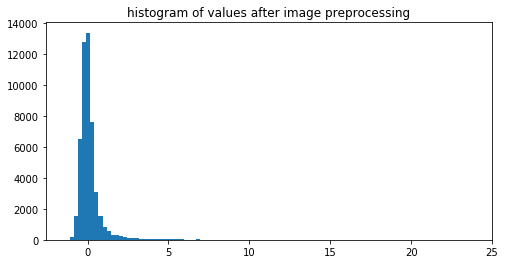

In [12]:
print(x.min(), x.max())
print(x[0:5,0:5])

plt.figure(figsize=(8,4))
plt.title('histogram of values after image preprocessing')
plt.hist(x.reshape(-1), bins=100)

1

### Load pretrained networks

In [13]:
vgg16 = VGG16(weights='imagenet',include_top=True,input_shape=(224,224,3))
r50 = ResNet50(weights='imagenet',include_top=False,input_shape=(224,224,3))

### Read metadata file

In [14]:
df =  pd.read_fwf('metaData.dat', comment = '#')
df.columns = df.iloc[9,:].values
df = df[10:]
df.head()

,SDSS_ID,RA,DEC,D25,redshi,logMst,err_l,GalSize_kpc,D_Mpc,d_pix_kpc
10,1237662635825954925,210.95489999999998,12.64455,0.33113110693986714,0.1029,-99.0,-99.0,42.47806067869379,440.99999325616017,0.8552113203991983
11,1237652947452297303,0.84015,-9.98328,0.5248074948227709,0.0767,11.312,0.016,50.181626715917524,328.7142940929958,0.6374607478101917
12,1237652899137912944,1.0026,-11.17802,0.6165950323262803,0.0383,9.708,0.071,29.440699795795908,164.1428577048438,0.3183148122868964
13,1237661433779716229,211.48905000000002,43.88251,0.7585775667003197,0.0337,9.26,0.062,31.869792393005813,144.4285735487938,0.28008379359836033
14,1237652944786555077,1.48395,16.13445,0.3388441338170015,0.0909,10.7,0.04,38.39840364463448,389.571413397789,0.7554782039377076


In [15]:
df['RA'] = df['RA'].apply(np.float64)
df['DEC'] = df['DEC'].apply(np.float64)
df['D25'] = df['D25'].apply(np.float64)
df['redshi'] = df['redshi'].apply(np.float64)
df['logMstar'] = df['logMst'].apply(np.float64) #renamed
df['err_logMstar'] = df['err_l'].apply(np.float64) #renamed
df['GalSize_kpc'] = df['GalSize_kpc'].apply(np.float64)
df['Distance'] = df['D_Mpc'].apply(np.float64) #renamed
df['d_pix_kpc'] = df['d_pix_kpc'].apply(np.float64)

df['lin_mass'] = np.power(10, df.logMstar)
df['lin_err'] = df['lin_mass'] * np.log(10) * df.err_logMstar

df = df.drop(['logMst','err_l'], axis=1)
df.describe()

,RA,DEC,D25,redshi,GalSize_kpc,d_pix_kpc,logMstar,err_logMstar,Distance,lin_mass,lin_err
count,187742.000000,187742.000000,187742.000000,187742.000000,187742.000000,187742.000000,187742.000000,187742.000000,187742.000000,1.877420e+05,1.877420e+05
mean,184.527190,24.898677,0.445798,0.074652,38.318105,0.620438,9.081941,-1.313631,319.936358,7.877701e+10,4.648110e+09
std,61.620064,19.374103,0.168006,0.040143,18.942158,0.333632,12.706553,11.469736,172.041273,9.461819e+10,5.529011e+09
min,0.008250,-11.252830,0.316228,0.010000,4.034125,0.083111,-99.000000,-99.000000,42.857142,1.000000e-99,-2.279559e-97
25%,152.349938,8.662358,0.346737,0.044100,25.157782,0.366519,10.191000,0.021000,189.000006,1.552387e+10,1.144774e+09
50%,185.824575,23.197910,0.389045,0.069000,35.525868,0.573465,10.693000,0.029000,295.714278,4.931738e+10,2.906879e+09
75%,222.151537,39.835143,0.478630,0.096400,48.283920,0.801189,11.032000,0.041000,413.142858,1.076465e+11,6.027530e+09
max,359.994900,70.133250,10.964781,0.299600,1373.931687,2.490003,12.326000,0.800000,1284.000022,2.118361e+12,1.727792e+11


In [16]:
# df.SDSS_ID[:20].apply(lambda x: x)
df['hasFile'] = df.SDSS_ID.apply(lambda x: os.path.isfile(dataFolder+x+'.npy'))

print("data file present:", len(df[df['hasFile']==True]))
print("data file missing:", len(df[df['hasFile']==False]))

data file present: 80306
data file missing: 107436


### Filter images that have no known mass, no actual image, or with an unknown error

In [17]:
df = df[df.logMstar != -99]
df = df[df.hasFile == True]
df = df[df['lin_err']!=0]
df.describe()

,RA,DEC,D25,redshi,GalSize_kpc,d_pix_kpc,logMstar,err_logMstar,Distance,lin_mass,lin_err
count,78851.000000,78851.000000,78851.000000,78851.000000,78851.000000,78851.000000,78851.000000,78851.000000,78851.000000,7.885100e+04,7.885100e+04
mean,185.303775,25.672447,0.557644,0.058701,38.101843,0.487867,10.558197,0.031070,251.574576,7.898269e+10,4.398954e+09
std,57.111612,18.944782,0.194465,0.032567,19.838329,0.270663,0.654456,0.016953,139.570856,9.624108e+10,5.552716e+09
min,0.009450,-11.238420,0.407380,0.010000,5.248929,0.083111,7.376000,0.001000,42.857142,2.376840e+07,4.756699e+05
25%,154.486425,9.795145,0.436516,0.033800,24.390653,0.280915,10.200000,0.019000,144.857136,1.584893e+10,1.023221e+09
50%,186.753000,24.400580,0.489779,0.052300,35.043089,0.434670,10.692000,0.028000,224.142852,4.920395e+10,2.693666e+09
75%,221.979375,40.093400,0.602560,0.075600,47.500516,0.628319,11.030000,0.039000,323.999992,1.071519e+11,5.603185e+09
max,359.994900,70.133250,10.964781,0.294800,1373.931687,2.450110,12.326000,0.778000,1263.428628,2.118361e+12,1.414535e+11


In [18]:
random.seed(42)

df = df.sample(frac=1).reset_index(drop=True)

In [19]:
df.head()

,SDSS_ID,RA,DEC,D25,redshi,GalSize_kpc,D_Mpc,d_pix_kpc,logMstar,err_logMstar,Distance,lin_mass,lin_err,hasFile
0,1237662336790167743,236.04390,34.66968,0.407380,0.0730,37.074235,312.85713825907027,0.606710,11.034,0.026,312.857138,1.081434e+11,6.474244e+09,True
1,1237658304351240275,154.01400,56.79250,0.457088,0.0454,25.870524,194.57143332277025,0.377324,10.785,0.030,194.571433,6.095369e+10,4.210532e+09,True
2,1237648722295914556,160.47255,0.79317,0.912011,0.0188,21.375051,80.571427409138,0.156249,9.788,0.040,80.571427,6.137620e+09,5.652957e+08,True
3,1237651252053672362,249.72450,43.84711,0.416869,0.0576,29.934487,246.85713861669814,0.478719,10.487,0.035,246.857139,3.069022e+10,2.473339e+09,True
4,1237651753998155847,152.12385,2.12103,0.426580,0.0716,38.076966,306.85713248593464,0.595074,11.077,0.033,306.857132,1.193988e+11,9.072555e+09,True


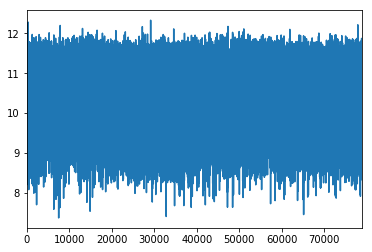

In [20]:
df.logMstar.plot()

In [21]:
print(len(df.SDSS_ID.values))

78851


# Iteration parameters defined here:

- N is the number of galaxies to use for this run
- M is the number of galaxies to train set (rest is holdout)
- chunkSize is the number of galaxies to evaluate at once
- prefixThisRound is the model name, for serialization purposes

In [22]:
N = int(len(df.SDSS_ID.values))
M = int(N*.9)
prefixThisRound = 'sp'
for i in runNameParams:
    prefixThisRound = prefixThisRound + '-' + i

chunkSize = 500
# N = 3000 # number of galaxies to take into consideration
# M = 2000 # train vs holdout


In [23]:
ids = df.SDSS_ID.values[:N]
Y = df.logMstar.values[:N]
err = df.err_logMstar.values[:N]
Y_lin = df.lin_mass.values[:N]
err_lin = df.lin_err.values[:N]

In [24]:
print(N)
print(M)
print(chunkSize)
print(prefixThisRound)

78851
70965
500
sp-newSource-ReadLog1pNormCrop.75


In [25]:
# crap instruction to make the auto execution stop here :p

### call img_preproc on all images, per batches of "chunkSize"
### Generate features based on the preprocessed images, pretrained networks and flux densities

In [26]:
def chunkFileName(chunkSize, prefix, chunkNumber):
    fileName = 'Xg3-'+str(chunkSize)+'-'+prefix+'-chunk-' + str(chunkNumber) + '.npy'
    return fileName

In [27]:
reloadImagesAndPreprocess = 0
maxChunkNumber = math.ceil(len(ids)/chunkSize)

Xg3r50 = []
Xg3vgg16 = []
postImgFeatures = []
csize=2
preImgFeatures = []

chunkStart = 0
# for chunkStart in tqdm(range(0, 3)):
for chunkStart in tqdm(range(0, len(ids), chunkSize)):
    curChunk = int((chunkStart//chunkSize))
    valuesInThisChunk = min(chunkStart+chunkSize,len(ids))-chunkStart

    Xg_ = []
    pre_ex_ = []

    # preprocess the image and collect some raw image stats
    for i in range(chunkStart, chunkStart+valuesInThisChunk):
        X = read_image(ids[i])
        Xg_.append(img_preprocnoread(X))
        pre_ex_.append([
            X.sum(),
            X.min(),
            X.max(),
            X.mean(),
            X.std(),
            X[X.shape[0]//2,X.shape[1]//2],
            np.mean(X[X.shape[0]//2-csize:X.shape[0]//2+csize,X.shape[1]//2-csize:X.shape[1]//2+csize]), # mean center
            X.shape[0], 
        ])

    # reformat the postprocessing
    pre_ex = np.stack(pre_ex_)
    Xg = np.stack(Xg_)

    # collect some post processing stats
    post_ex = np.hstack([
        np.sum(Xg.reshape(valuesInThisChunk,-1),axis=1).reshape(valuesInThisChunk,1),
        np.min(Xg.reshape(valuesInThisChunk,-1),axis=1).reshape(valuesInThisChunk,1),
        np.max(Xg.reshape(valuesInThisChunk,-1),axis=1).reshape(valuesInThisChunk,1),
        np.mean(Xg.reshape(valuesInThisChunk,-1),axis=1).reshape(valuesInThisChunk,1),
        np.std(Xg.reshape(valuesInThisChunk,-1),axis=1).reshape(valuesInThisChunk,1),
        Xg[:,112,112].reshape(valuesInThisChunk,1),       # center
        np.mean(Xg[:,112-csize:112+csize,112-csize:112+csize].reshape(valuesInThisChunk,-1),axis=1).reshape(valuesInThisChunk,-1) # mean center
        ])

    Xg3 = np.zeros((valuesInThisChunk,224,224,3))
    Xg3[:,:,:,:] = Xg.reshape(valuesInThisChunk,224,224,1)
    
    # do r50 prediction
    Xg3r50_ = r50.predict(Xg3).reshape(valuesInThisChunk, 2048)
    Xg3vgg16_ = vgg16.predict(Xg3)


    if chunkStart == 0:
        Xg3r50 = Xg3r50_
        Xg3vgg16 = Xg3vgg16_
        preImgFeatures = pre_ex
        postImgFeatures = post_ex
    else:
        Xg3r50 = np.concatenate([Xg3r50,Xg3r50_], axis=0)
        Xg3vgg16 = np.concatenate([Xg3vgg16,Xg3vgg16_], axis=0)
        preImgFeatures = np.concatenate([preImgFeatures,pre_ex], axis=0)
        postImgFeatures = np.concatenate([postImgFeatures,post_ex], axis=0)
        
print('done')

postImgFeatureNames = ['norm.flux.sum', 'norm.flux.min',
                       'norm.flux.max', 'norm.flux.mean', 
                       'norm.flux.std', 'center.flux', 
                       'aroundCenter.flux']
preImgFeatureNames = ['pre.flux.sum', 'pre.flux.min', 
                      'pre.flux.max', 'pre.flux.mean',
                      'pre.flux.std', 'pre.center.flux',
                      'pre.aroundCenter.flux', 'width']



100%|██████████| 158/158 [10:50<00:00,  3.97s/it]

done


In [28]:
Xg3 = None
Xg = None
X = None


In [29]:
Distance = df.Distance.values[:N].reshape(N,1)

Xg3f = np.hstack ( ( 
        Xg3r50, 
        Xg3vgg16, 
        Distance,
        1/Distance,
        Distance**2,
        1/(Distance**2),
        Distance**3,
        1/(Distance**3),
        np.log(Distance),
        1/np.log(Distance),
        np.log(Distance**2),
        1/np.log(Distance**2),
        np.log(Distance)**2,
        1/np.log(Distance)**2,
        preImgFeatures,
        postImgFeatures
        ) )

distanceNames = ['D', '1/D', 'D**2', '1/D**2', 'D**3', '1/D**3', 'log(D)', '1/log(D)', 'log(D**2)', 'log(1/D**2)', 'log(D)**2', '1/log(D)**2' ]

In [30]:
prefixThisRound = prefixThisRound + '-model5'

In [31]:
# extraImgFeatureNames = ['norm.flux.sum', 'norm.flux.min', 'norm.flux.max', 'norm.flux.mean', 'norm.flux.std', 'center.flux', 'aroundCenter.flux']

Xg3fNames = ( [prefixThisRound+'.r50.' + str(i) for i in range(Xg3r50.shape[1])]
            + [prefixThisRound+'.vgg16.' + str(i) for i in range(Xg3vgg16.shape[1])] 
            + [prefixThisRound+'.'+ n for n in distanceNames]
            + [prefixThisRound+'.'+ n for n in preImgFeatureNames]
            + [prefixThisRound+'.'+ n for n in postImgFeatureNames])

print(len(Xg3fNames), Xg3f.shape)

3075 (78851, 3075)


In [32]:
print(Xg3f.shape)
print(df.shape)

t1 = df.SDSS_ID.values[:N].reshape(N,1)
t2 = Xg3f[:N,:]
t3 = np.concatenate((t1,t2), axis=1)
np.save(prefixThisRound+str(N), t3)
np.save(prefixThisRound+str(N) + 'featurenames', Xg3fNames)
del t1, t2, t3

(78851, 3075)
(78851, 14)


In [33]:

# if os.path.isfile(prefixThisRound +str(N)+'.npy'):
#     t3 = np.load(prefixThisRound+str(N)+'.npy')
#     Xg3fNames = np.load(prefixThisRound+str(N) + 'featurenames' + '.npy', )
# Xg3f = t3[:,1:]
# Xg3f.shape

In [34]:
# Xg3f = t3[:,1:]
# Xg3f.shape

### Generate the train/test datasets for lgbm regression

In [35]:
# N = len(df.SDSS_ID.values)
# M = 4000

# N = 10000
# M = 10000
print(M, N)

70965 78851


In [36]:
dtrain = lgbm.Dataset(Xg3f[:M], label= Y[:M])
dtest = lgbm.Dataset(Xg3f[M:], label= Y[M:])


In [37]:

lgbm_params = {
    'boosting_type': 'gbdt',
    'objective': 'regression_l2',
    'nthread': 4,
    #'silent': True,
    'num_leaves': 2**4,
    'learning_rate': 0.01,
    'max_depth': 10,
    'max_bin': 255,
    #'subsample_for_bin': 50000,
    #'subsample': 0.8,
    #'subsample_freq': 1,
    #'colsample_bytree': 0.8,
    #'reg_alpha': 1,
    #'reg_lambda': 0,
    #'min_split_gain': 0.5,
    #'min_child_weight': 1,
    #'min_child_samples': 60,
    #'scale_pos_weight': 1,
    'device' : 'gpu',
    'metric' : 'rmse',
    #'metric' : 'multi_error',
    'verbose':0,          
}

In [38]:

# num_boost_round = len(bst['rmse-mean'])-1
num_boost_round = 29999
print(num_boost_round)


29999


In [39]:
from sklearn.metrics import *

def lgb_rmsle(y_pred,y_true):
   return 'rmsle', mean_squared_error(np.log1p(y_true.get_label()),np.log1p(y_pred)), False

In [40]:
num_boost_round = 1000

model = lgbm.train(lgbm_params, dtrain, num_boost_round,
                   valid_sets=[dtest], valid_names=['test'], fobj=None, feval=lgb_rmsle, 
                   init_model=None, feature_name='auto', categorical_feature='auto', 
                   early_stopping_rounds=100, evals_result=None, verbose_eval=20, 
                   learning_rates=None, callbacks=None)


Training until validation scores don't improve for 100 rounds.
[20]	test's rmse: 0.569429	test's rmsle: 0.00259745
[40]	test's rmse: 0.499067	test's rmsle: 0.00200729
[60]	test's rmse: 0.442109	test's rmsle: 0.00158192
[80]	test's rmse: 0.396479	test's rmsle: 0.00127541
[100]	test's rmse: 0.359826	test's rmsle: 0.00105143
[120]	test's rmse: 0.330234	test's rmsle: 0.000885491
[140]	test's rmse: 0.306854	test's rmsle: 0.000763867
[160]	test's rmse: 0.288752	test's rmsle: 0.00067558
[180]	test's rmse: 0.27499	test's rmsle: 0.000612124
[200]	test's rmse: 0.264009	test's rmsle: 0.000563637
[220]	test's rmse: 0.25485	test's rmsle: 0.000524641
[240]	test's rmse: 0.247333	test's rmsle: 0.000493634
[260]	test's rmse: 0.241261	test's rmsle: 0.000469312
[280]	test's rmse: 0.236254	test's rmsle: 0.000449825
[300]	test's rmse: 0.232109	test's rmsle: 0.000434061
[320]	test's rmse: 0.228566	test's rmsle: 0.000420787
[340]	test's rmse: 0.225553	test's rmsle: 0.000409651
[360]	test's rmse: 0.222867	tes

In [41]:
pred = model.predict(Xg3f[M:])

In [42]:
print(Y[M:].shape)
print(pred.shape)

(7886,)
(7886,)


In [43]:
chiSq = xi2(Y[M:],pred,err[M:])
linChiSq = xi2(10**Y[M:],10**pred,err_lin[M:])
print(chiSq)
print(linChiSq)


127.514883277
131.550875663


In [44]:
print(N,(M,N-M), prefixThisRound, chiSq, linChiSq)
# 7885 (6308, 1577) sp-newSource-ReadNormCrop.5-model1 65.6004981632 289.265891446
# 78851 (63080, 15771) sp-newSource-ReadNormCrop.5-model1 101.26977686 3634.92854724
# 78851 (70965, 7886) sp-newSource-ReadNormCrop.5-model1 84.7537916939 112.786722095
# 78851 (70965, 7886) sp-newSource-ReadNormCrop.5-model1-model2 76.9540798979 106.544584929
# 78851 (70965, 7886) sp-newSource-ReadLog1pNormCrop.5-model3 64.4120566007 82.1151002172
# 78851 (70965, 7886) sp-newSource-ReadLog1pNormCrop.75-model4 72.2302974915 78.0009050209
# 78851 (70965, 7886) sp-newSource-ReadLog1pCrop.75Norm-model4 74.433987693 104.167079904
# 78851 (70965, 7886) sp-newSource-ReadLog1pNormCrop.75-model4 66.7288440316 76.8328009721
# 78851 (70965, 7886) sp-newSource-ReadLog1pNormCrop.75-model4 65.4574681665 81.7908427327
# 78851 (70965, 7886) sp-newSource-ReadLog1pNormCrop.75-model4 72.7632221466 98.9424959642
# 78851 (70965, 7886) sp-newSource-ReadLog1pNormCrop.6-model5 69.4944311297 99.8518732071
# 78851 (70965, 7886) sp-newSource-ReadLog1pNormCrop.75-model5 60.9081327724 97.7560407261

78851 (70965, 7886) sp-newSource-ReadLog1pNormCrop.75-model5 127.514883277 131.550875663


In [45]:
# investigateIDOffset = 2815

# df.loc[M+investigateIDOffset,:]

# print(10**pred[investigateIDOffset]/10**Y[M+investigateIDOffset], 10**Y[M+investigateIDOffset])

# drawOneGalaxy(df.loc[M+investigateIDOffset,'SDSS_ID'])

In [46]:
# def xi2_max(true,pred,error):
#     s=np.argmax((true-pred)**2/error**2)
    
#     plt.hist(np.log(0.00001+(true-pred)**2/error**2),bins=100)
#     return s

In [47]:
# # M = N-4000
# pred[2815] = Y[M+2815]

# print( xi2_max(10**Y[M:],10**pred,err_lin[M:]))


# Same but with Cross Validation

In [48]:
lgbm_params = {
    'boosting_type': 'gbdt',
    'objective': 'regression_l2',
    'nthread': 4,
    #'silent': True,
    'num_leaves': 2**4,
    'learning_rate': 0.01,
    'max_depth': 10,
    'max_bin': 255,
    #'subsample_for_bin': 50000,
    #'subsample': 0.8,
    #'subsample_freq': 1,
    #'colsample_bytree': 0.8,
    #'reg_alpha': 1,
    #'reg_lambda': 0,
    #'min_split_gain': 0.5,
    #'min_child_weight': 1,
    #'min_child_samples': 60,
    #'scale_pos_weight': 1,
    'device' : 'gpu',
    'metric' : 'rmse',
    #'metric' : 'multi_error',
    'verbose':0,          
}

In [49]:
from sklearn.model_selection import *

In [55]:
# %%time
nSplits = 5
kf = KFold(n_splits=nSplits,shuffle=True, random_state=220673)

ppreds = np.zeros([len(Xg3f),nSplits])
models = []
xis, linxis = [],[]
counter = 0
for tix, vix in kf.split(Xg3f[:M]):
    X_train, X_test = Xg3f[tix], Xg3f[vix]
    Y_train, Y_test = Y[tix], Y[vix]
    
    lgb_train = lgbm.Dataset(X_train, Y_train)
    lgb_eval = lgbm.Dataset(X_test, Y_test)
    
    gbm = lgbm.train(lgbm_params,
                       lgb_train,
                       num_boost_round=20000,
                       valid_sets=[lgb_train,lgb_eval],  # eval training data
                       verbose_eval=100,
                       early_stopping_rounds=100
                    )
    models.append(gbm)
    
    p = gbm.predict(X_test)
    chiSq = xi2(Y_test,p,err[vix])
    linChiSq = xi2(10**Y_test,10**p,err_lin[vix])
    xis.append(chiSq)
    linxis.append(linChiSq)
    print(counter,chiSq,linChiSq)    
    
    ppreds[vix,counter] = p
    counter = counter+1

    
# def lgb_r2(y_pred,y_true):
#    return ‘r2’, r2_score(y_true.get_label(),y_pred), True


# [6:28] 
# gbm.predict(X_test,gbm.best_iteration)

Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 0.356304	valid_1's rmse: 0.354423
[200]	training's rmse: 0.25864	valid_1's rmse: 0.259426
[300]	training's rmse: 0.226161	valid_1's rmse: 0.22877
[400]	training's rmse: 0.211762	valid_1's rmse: 0.215947
[500]	training's rmse: 0.203043	valid_1's rmse: 0.208763
[600]	training's rmse: 0.196647	valid_1's rmse: 0.203893
[700]	training's rmse: 0.191672	valid_1's rmse: 0.20036
[800]	training's rmse: 0.187661	valid_1's rmse: 0.197677
[900]	training's rmse: 0.184353	valid_1's rmse: 0.195699
[1000]	training's rmse: 0.181469	valid_1's rmse: 0.194087
[1100]	training's rmse: 0.178969	valid_1's rmse: 0.192792
[1200]	training's rmse: 0.176726	valid_1's rmse: 0.191674
[1300]	training's rmse: 0.174697	valid_1's rmse: 0.190801
[1400]	training's rmse: 0.17286	valid_1's rmse: 0.190035
[1500]	training's rmse: 0.171145	valid_1's rmse: 0.189379
[1600]	training's rmse: 0.169558	valid_1's rmse: 0.188808
[1700]	training's rmse

[1200]	training's rmse: 0.176391	valid_1's rmse: 0.195634
[1300]	training's rmse: 0.174378	valid_1's rmse: 0.194668
[1400]	training's rmse: 0.172529	valid_1's rmse: 0.193844
[1500]	training's rmse: 0.170822	valid_1's rmse: 0.193139
[1600]	training's rmse: 0.169201	valid_1's rmse: 0.192512
[1700]	training's rmse: 0.167694	valid_1's rmse: 0.191979
[1800]	training's rmse: 0.166256	valid_1's rmse: 0.191462
[1900]	training's rmse: 0.164896	valid_1's rmse: 0.191035
[2000]	training's rmse: 0.163602	valid_1's rmse: 0.190649
[2100]	training's rmse: 0.162348	valid_1's rmse: 0.190304
[2200]	training's rmse: 0.16116	valid_1's rmse: 0.19004
[2300]	training's rmse: 0.160005	valid_1's rmse: 0.189764
[2400]	training's rmse: 0.158886	valid_1's rmse: 0.189472
[2500]	training's rmse: 0.157806	valid_1's rmse: 0.189225
[2600]	training's rmse: 0.15676	valid_1's rmse: 0.188986
[2700]	training's rmse: 0.155736	valid_1's rmse: 0.18876
[2800]	training's rmse: 0.154747	valid_1's rmse: 0.188578
[2900]	training's 

[1600]	training's rmse: 0.169446	valid_1's rmse: 0.190812
[1700]	training's rmse: 0.167967	valid_1's rmse: 0.190379
[1800]	training's rmse: 0.166547	valid_1's rmse: 0.189953
[1900]	training's rmse: 0.165178	valid_1's rmse: 0.189587
[2000]	training's rmse: 0.163861	valid_1's rmse: 0.189239
[2100]	training's rmse: 0.162585	valid_1's rmse: 0.188882
[2200]	training's rmse: 0.161376	valid_1's rmse: 0.188562
[2300]	training's rmse: 0.160222	valid_1's rmse: 0.188304
[2400]	training's rmse: 0.159102	valid_1's rmse: 0.188081
[2500]	training's rmse: 0.157976	valid_1's rmse: 0.187822
[2600]	training's rmse: 0.156901	valid_1's rmse: 0.187597
[2700]	training's rmse: 0.155885	valid_1's rmse: 0.187401
[2800]	training's rmse: 0.154873	valid_1's rmse: 0.187219
[2900]	training's rmse: 0.153891	valid_1's rmse: 0.187069
[3000]	training's rmse: 0.15291	valid_1's rmse: 0.186901
[3100]	training's rmse: 0.151979	valid_1's rmse: 0.186751
[3200]	training's rmse: 0.151079	valid_1's rmse: 0.186623
[3300]	training

[5400]	training's rmse: 0.134976	valid_1's rmse: 0.179291
[5500]	training's rmse: 0.13431	valid_1's rmse: 0.179212
[5600]	training's rmse: 0.133662	valid_1's rmse: 0.179162
[5700]	training's rmse: 0.133012	valid_1's rmse: 0.179082
[5800]	training's rmse: 0.132364	valid_1's rmse: 0.17902
[5900]	training's rmse: 0.131726	valid_1's rmse: 0.178954
[6000]	training's rmse: 0.131093	valid_1's rmse: 0.178901
[6100]	training's rmse: 0.130478	valid_1's rmse: 0.178855
[6200]	training's rmse: 0.129862	valid_1's rmse: 0.178807
[6300]	training's rmse: 0.129256	valid_1's rmse: 0.178775
[6400]	training's rmse: 0.128654	valid_1's rmse: 0.178724
[6500]	training's rmse: 0.128059	valid_1's rmse: 0.178669
[6600]	training's rmse: 0.127479	valid_1's rmse: 0.178639
[6700]	training's rmse: 0.126879	valid_1's rmse: 0.178596
[6800]	training's rmse: 0.126299	valid_1's rmse: 0.178553
[6900]	training's rmse: 0.125724	valid_1's rmse: 0.178517
[7000]	training's rmse: 0.125145	valid_1's rmse: 0.178469
[7100]	training'

[7400]	training's rmse: 0.122403	valid_1's rmse: 0.178883
[7500]	training's rmse: 0.121863	valid_1's rmse: 0.178852
[7600]	training's rmse: 0.121308	valid_1's rmse: 0.178795
[7700]	training's rmse: 0.120771	valid_1's rmse: 0.178761
[7800]	training's rmse: 0.120234	valid_1's rmse: 0.178721
[7900]	training's rmse: 0.119704	valid_1's rmse: 0.178683
[8000]	training's rmse: 0.119192	valid_1's rmse: 0.17865
[8100]	training's rmse: 0.118675	valid_1's rmse: 0.178612
[8200]	training's rmse: 0.11817	valid_1's rmse: 0.178581
[8300]	training's rmse: 0.117669	valid_1's rmse: 0.178557
[8400]	training's rmse: 0.117164	valid_1's rmse: 0.178522
[8500]	training's rmse: 0.11667	valid_1's rmse: 0.178483
[8600]	training's rmse: 0.116152	valid_1's rmse: 0.178449
[8700]	training's rmse: 0.115651	valid_1's rmse: 0.178402
[8800]	training's rmse: 0.115165	valid_1's rmse: 0.178367
[8900]	training's rmse: 0.114678	valid_1's rmse: 0.178334
[9000]	training's rmse: 0.114195	valid_1's rmse: 0.178304
[9100]	training's

In [57]:
linxis

[3190.0017257791174,
 106.1988746984362,
 127.39834482925274,
 194.12387068636971,
 112.13836487503674]

In [60]:
ppreds = np.zeros([len(models),N-M])
for i, m in zip(range(len(models)),models):
    mp = m.predict(Xg3f[M:])
    ppreds[i] = mp



In [62]:
ppreds.shape

(5, 7886)

In [69]:
cvpred = ppreds.mean(axis=0)

chiSq = xi2(Y[M:],cvpred,err[M:])
linChiSq = xi2(10**Y[M:],10**cvpred,err_lin[M:])
print(chiSq)
print(linChiSq)    


87.1067327615
98.6700130948


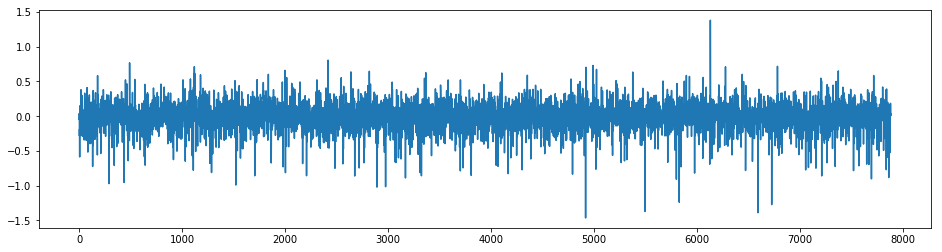

In [70]:
plt.figure(figsize=(16,4))
plt.plot(Y[M:]-cvpred)

10.788
SDSS_ID         1237661949191520436
RA                          209.934
DEC                         10.9285
D25                         0.42658
redshi                       0.0787
GalSize_kpc                 41.8528
D_Mpc             337.2857081038611
d_pix_kpc                  0.654083
logMstar                     10.788
err_logMstar                  0.026
Distance                    337.286
lin_mass                6.13762e+10
lin_err                 3.67442e+09
hasFile                        True
Name: 6132, dtype: object
1237661949191520436


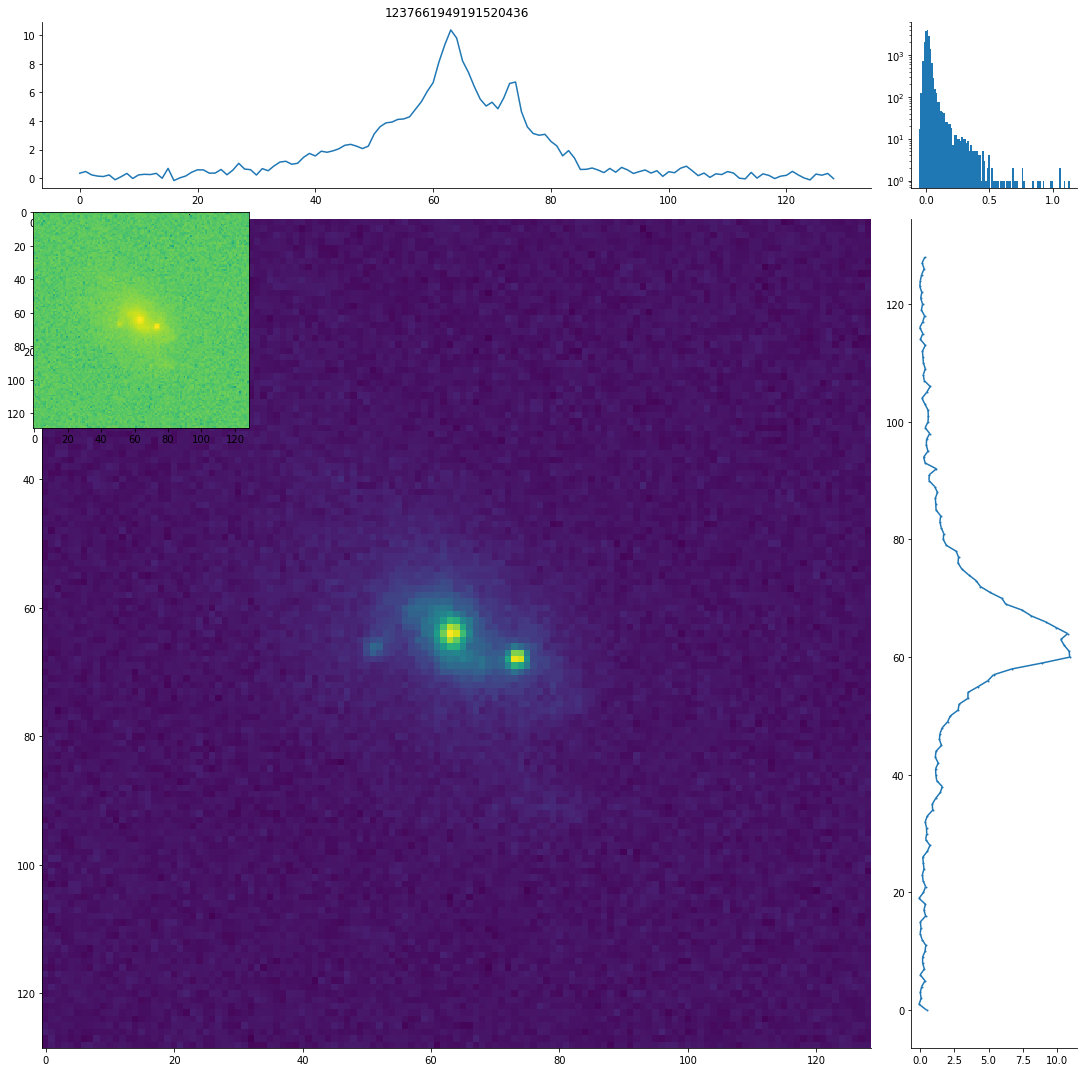

In [74]:
badID = np.argmax(Y[M:]-cvpred)
print(Y[badID])
print(df.loc[badID])
# df['cvpred'] = cvpred
# df['lincvpred'] = 10**cvpred
# df['deltapred'] = abs(Y[M:]-cvpred)
# df['lindeltapred'] = 10**Y[M:]-10**cvpred

drawOneGalaxy(df.SDSS_ID[badID])


In [ ]:
print(prefixThisRound)

# df.to_csv(prefixThisRound + '-CVResultDF.csv')

In [ ]:
df.sort_values(by='deltapred', ascending=False).iloc[:20,:]

In [ ]:
sns.jointplot(x=Y, y=cvpred, kind='reg')
plt.title('log reg')
sns.jointplot(x=Y, y=cvpred, kind='resid')
plt.title('log residuals')

sns.jointplot(x=10**Y, y=10**cvpred, kind='reg')
plt.title('log reg')
sns.jointplot(x=10**Y, y=10**cvpred, kind='resid')
plt.title('log residuals')


# Model is trained, values are obtained, saving and result analysis below

In [ ]:
# break here, save the stuff below

In [ ]:
arr = model.feature_importance()
print(arr.shape)
np.argmax(arr)
# print(arr)

In [ ]:
fimport = list(zip(arr, Xg3fNames))
sorted(fimport, key=lambda x: x[0], reverse=True)[:50]

In [ ]:
sns.jointplot(x=Y[M:], y=pred, kind='kde')
plt.title('log kde')
sns.jointplot(x=Y[M:], y=pred, kind='reg')
plt.title('log reg')
sns.jointplot(x=Y[M:], y=pred, kind='resid')
plt.title('log residuals')


sns.jointplot(x=10**Y[M:], y=10**pred, kind='kde')
plt.title('lin kde')
sns.jointplot(x=10**Y[M:], y=10**pred, kind='reg')
plt.title('lin joint')
sns.jointplot(x=10**Y[M:], y=10**pred, kind='resid')
plt.title('lin joint')
# plt.scatter(x=10**Y[M:], y=10**pred)


In [ ]:
df[df['logMstar']>=12]

In [ ]:
print(df.shape)
print(pred.shape)

In [ ]:
plt.plot(10**Y[M:]-10**pred)
worstID = np.argmax(10**Y[M:]-10**pred)

print(Y[M+worstID], pred[worstID])
print(10**Y[M+worstID], 10**pred[worstID])
print(df.loc[M+worstID,:]) # 1237664105244524770, 1237661851469611060 1237654626789163411

# pred[worstID] = Y[M+worstID]

drawOneGalaxy(df.loc[M+worstID,'SDSS_ID'])

In [ ]:
# Warning: predictions from here on will contain data from training set: 
pred = model.predict(Xg3f[:])



In [ ]:
pred.shape

In [ ]:
df['pred'] = pred
df['lin_pred'] = 10**pred

In [ ]:
plt.plot(Y[:]-pred)

In [ ]:
sns.jointplot(data=df, x='lin_pred', y='lin_mass', kind='reg')
plt.title('lin kde')
